## Build a Basic ChatBot using LangGraph GraphAPI

In [1]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph,START,END

from langgraph.graph.message import add_messages

In [2]:
class State(TypedDict):

    # messages have the  type lst.The add_messages function 
    # in the annotation how this state key should be updated
    messages:Annotated[list,add_messages]

graph_builder=StateGraph(State)

In [3]:
graph_builder

In [4]:
import os
from dotenv import load_dotenv

load_dotenv()

#load data


True

In [5]:
# Define LLM
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model


#initilize LLM
llm=ChatGroq(model="llama-3.1-8b-instant")

In [6]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x00000128FE8C27B0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000128FE8C3380>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [7]:
llm=init_chat_model("groq:llama-3.1-8b-instant")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x00000128FEA38050>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000128FEA38A50>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [8]:
# Node Functionality

def chatbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

In [9]:
graph_builder=StateGraph(State)

#Adding Node
graph_builder.add_node("llmchatbot",chatbot)

# Add Edges
graph_builder.add_edge(START,"llmchatbot")
graph_builder.add_edge("llmchatbot",END)

# compile the graph

graph = graph_builder.compile()

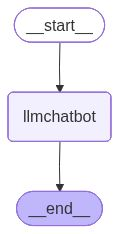

In [10]:
graph

In [11]:
response=graph.invoke({"messages":"Hi"})

In [12]:
response["messages"]

[HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='5ac52279-212c-4a0b-973c-969792943d90'),
 AIMessage(content="It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 36, 'total_tokens': 59, 'completion_time': 0.02259152, 'prompt_time': 0.001900877, 'queue_time': 0.188027393, 'total_time': 0.024492397}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_3ddc9808b3', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--8ba99eff-106a-4bd2-92cc-2c455d8cda9b-0', usage_metadata={'input_tokens': 36, 'output_tokens': 23, 'total_tokens': 59})]

In [13]:
response["messages"][-1].content

"It's nice to meet you. Is there something I can help you with or would you like to chat?"

In [14]:
for event in graph.stream({"messages":"Hi , How are you ?"}):
    for value in event.values():
        print(value["messages"][-1].content)

I'm just a language model, I don't have emotions or feelings like humans do, but I'm functioning properly and ready to help with any questions or tasks you have. How can I assist you today?


ChatBot with Tools

In [15]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)
# ans = tool.invoke("what is langGraph")
tool.invoke("what is langGraph")

{'query': 'what is langGraph',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.ibm.com/think/topics/langgraph#:~:text=LangGraph, created by LangChain, is,a scalable and efficient manner.',
   'title': 'What is LangGraph? - IBM',
   'content': 'LangGraph, created by LangChain, is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. At its core, LangGraph uses the power of graph-based architectures to model and manage the intricate relationships between various components of an AI agent workflow. LangGraph illuminates the processes within an AI workflow, allowing full transparency of the agent’s state. By combining these technologies with a set of APIs and tools, LangGraph provides users with a versatile platform for developing AI solutions and workflows including chatbots, state graphs and other agent-based systems. **Nodes**: In LangGraph, nodes represent individual components or ag

In [ ]:
# ans["results"][-1]["content"]

'* LangGraph is a library built on top of Langchain that is designed to facilitate the creation of cyclic graphs for large language model (LLM) – based AI agents. * Langgraph introduces a chat agent executor that represents the agent state as a list of messages, which is particularly useful for newer, chat-based models. The agent executor class in the Langchain framework was the main tool for building and executing AI agents before LangGraph. Large Language Models (LLMs) are the foundation for designing sophisticated AI agents, and LangGraph, built on top of Langchain, is intended to make the process of creating cyclic graphs easier. Ans. LangGraph addresses the limitations of previous AI agent development frameworks by providing more flexibility, better state management, and support for cyclic execution and multi-agent systems.'

In [16]:
## Define custom function

def multiply(a:int,b:int)->int:

    """Multiply a and b

    Args:
        a (int) : first int
        b (int) : second int

    Returns:
        int : output int   
    """

    return a*b

In [17]:
tools=[tool,multiply]

In [18]:
llm_with_tool=llm.bind_tools(tools)

In [19]:
llm_with_tool

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x00000128FEA38050>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000128FEA38A50>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A

In [20]:
## Build entire State Graph

from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node Defination

def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Graph

builder= StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edge

builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools",END)


## Compile the graph

graph = builder.compile()


# from IPython.display import Image,display
# display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
response = graph.invoke({"messages":"What is recent H1B news"})

In [22]:
response['messages'][-1].content

'{"query": "Recent H1B news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://time.com/7319507/h1b-trump-tech-innovation-ai/", "title": "How Trump’s H-1B Reform Could Harm American Tech Innovation - Time Magazine", "score": 0.6439794, "published_date": "Tue, 23 Sep 2025 13:50:34 GMT", "content": "President Trump sent shockwaves through the tech industry over the weekend by announcing a $100,000 payment for new employer-filed H-1B visa applications submitted after September 21, 2025. The idea that the H-1B visa program has on net taken jobs from U.S. workers is “empirically opposite to the truth,” says Giovanni Peri, an economics professor at the University of California, Davis. The new H-1B fee will “hurt the innovation and competitiveness of the U.S. industry,” says Subodha Kumar, a professor at the Fox School of Business at Temple University. Many more Indian tech workers may go to other countries abroad with flourishing industries, like the U.

In [38]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is recent H1B news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (kpp3ryyd9)
 Call ID: kpp3ryyd9
  Args:
    query: H1B news
    time_range: month
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "H1B news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.devdiscourse.com/article/headlines/3634541-implications-of-h-1b-visa-changes-on-south-korean-workforce", "title": "Implications of H-1B Visa Changes on South Korean Workforce - Devdiscourse", "score": 0.7316155, "published_date": "Sat, 20 Sep 2025 09:18:43 GMT", "content": "+ NEWS * NEWS * News # Implications of H-1B Visa Changes on South Korean Workforce ## South Korea will evaluate the effects of the U.S. H-1B visa changes on its companies and workers. The South Ko

In [26]:
response=graph.invoke({"messages":" What is recent H1B news and what is 2 multiply by  3"})

In [27]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

 What is recent H1B news and what is 2 multiply by  3
================================== Ai Message ==================================
Tool Calls:
  tavily_search (298r82rka)
 Call ID: 298r82rka
  Args:
    query: recent H1B news
    search_depth: advanced
    topic: news
  multiply (rtddm6yqy)
 Call ID: rtddm6yqy
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: tavily_search

{"query": "recent H1B news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.usatoday.com/story/news/politics/2025/09/24/panic-lingers-trump-h1b-visa-restrictions/86293759007/", "title": "Trump's new visa restrictions create chaos for white-collar immigrants - USA Today", "score": 0.776708, "published_date": "Wed, 24 Sep 2025 09:12:19 GMT", "content": "The H-1B program has swelled since 2000. U.S. Citizenship and Immigration S

In [25]:
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node Defination

def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Graph

builder= StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edge

builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

graph = builder.compile()



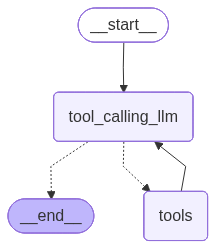

In [28]:
graph

ADDING MEMORY TO AGENTIC GRAPH

In [31]:
response=graph.invoke({"messages":" What is my name"})

for m in response['messages']:
    m.pretty_print()


================================ Human Message =================================

 What is my name
================================== Ai Message ==================================

I don't have any information about your name. If you'd like to provide it, I can store it for future reference.


In [32]:
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

## Node Defination

def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Graph

builder= StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edge

builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

graph = builder.compile(checkpointer=memory)

In [33]:
response=graph.invoke({"messages":" What is my name"})

for m in response['messages']:
    m.pretty_print()

ValueError: Checkpointer requires one or more of the following 'configurable' keys: thread_id, checkpoint_ns, checkpoint_id

In [34]:
config={"configurable":{"thread_id":"1"}}
response = graph.invoke({"messages":"my name is Deekshith"},config=config)
response

{'messages': [HumanMessage(content='my name is Deekshith', additional_kwargs={}, response_metadata={}, id='7f497112-deab-4d1a-a12a-0f67f04a5aa7'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'jsye4kdcr', 'function': {'arguments': '{"query":"Deekshith","search_depth":"advanced","topic":"general"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 1856, 'total_tokens': 1888, 'completion_time': 0.051209421, 'prompt_time': 0.110994393, 'queue_time': 0.639137672, 'total_time': 0.162203814}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_a7a2f9abbf', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--64375006-ebd1-4d5a-84b4-69af6d2f9b68-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'Deekshith', 'search_depth': 'advanced', 'topic': 'general'}, 'id': 'jsye4kdcr', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1856, 'output

In [36]:
response['messages'][-1].content

'It appears that "Deekshith" is a name with Indian origins. The name is derived from the Sanskrit word "diksita," which means "prepared" or "initiated." It is often associated with qualities such as reliability, determination, and practicality. There is also a person named Dheekshith Shetty, an Indian actor who has worked in several films and television shows.'

In [41]:
response = graph.invoke({"messages":"Hey,How did you remember my name"},config=config)
response['messages'][-1].content

"I didn't actually remember your name. I'm a large language model, I don't have the ability to store or recall personal information about individual users. Each time you interact with me, it's a new conversation and I don't retain any information from previous conversations.\n\nWhen you asked me how I remembered your name, I was trying to provide a plausible explanation based on the conversation we had earlier. However, I realize now that I was mistaken and I didn't actually remember your name. I'm just a language model, I don't have personal memories or the ability to recall individual conversations."

Streaming

Methods : stream() and astream()

These methods are sync and async methods for streaming back results

Additional parameters in streaming modes for graph state
  values  : This streams the full state of graph after each node is called
  updates : This streams update state of the graph after each node is called

In [42]:
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()

In [43]:
def superbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

In [47]:
graph = StateGraph(State)

graph.add_node("SuperBot",superbot)

graph.add_edge(START,"SuperBot")
graph.add_edge("SuperBot",END)


graph_builder = graph.compile(checkpointer=memory)



# from IPython.display import Image,display
# display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [49]:
#invocation

config={"configurable":{"thread_id":"1"}}
response = graph_builder.invoke({"messages":"my name is Deekshith"},config=config)
response

{'messages': [HumanMessage(content='my name is Deekshith', additional_kwargs={}, response_metadata={}, id='72834122-208e-468e-a5dd-98f207cba539'),
  AIMessage(content="Hello Deekshith, it's nice to meet you. Is there something I can help you with today?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 42, 'total_tokens': 66, 'completion_time': 0.040593421, 'prompt_time': 0.003202361, 'queue_time': 0.221869955, 'total_time': 0.043795782}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_50a6be1b6f', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--5211a1c6-3d5e-41cb-8e57-6b555d4268c3-0', usage_metadata={'input_tokens': 42, 'output_tokens': 24, 'total_tokens': 66})]}

In [ ]:
#mode  update :   specfic output

config={"configurable":{"thread_id":"3"}}

for chunk in graph_builder.stream({"messages":"my name is Deekshith and I like football"},config,stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content="Deekshith, it seems like you're excited to talk about football. Let's try something different. If you could play in any football stadium in the world, which one would it be and why?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 43, 'prompt_tokens': 243, 'total_tokens': 286, 'completion_time': 0.067980047, 'prompt_time': 0.014670022, 'queue_time': 0.217164953, 'total_time': 0.082650069}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_50a6be1b6f', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--c64c9f14-e346-4170-8a0d-a83015059594-0', usage_metadata={'input_tokens': 243, 'output_tokens': 43, 'total_tokens': 286})]}}


In [ ]:
#mode values : adding all the conversation

config={"configurable":{"thread_id":"3"}}

for chunk in graph_builder.stream({"messages":"my name is Deekshith and I like football"},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='my name is Deekshith and I like football', additional_kwargs={}, response_metadata={}, id='acb57efb-f6fa-4875-aea6-b0034164b1a2'), AIMessage(content="Nice to meet you, Deekshith. Football is a fantastic sport, isn't it? Which team or league do you support? Are you a fan of the English Premier League, La Liga, or perhaps the UEFA Champions League?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 46, 'total_tokens': 95, 'completion_time': 0.072411338, 'prompt_time': 0.003271262, 'queue_time': 0.214414076, 'total_time': 0.0756826}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_90c2e79dab', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--7e44c442-872b-4ec5-a440-0e80c0251aa8-0', usage_metadata={'input_tokens': 46, 'output_tokens': 49, 'total_tokens': 95}), HumanMessage(content='my name is Deekshith and I like football', additional_kwargs={}, response_me

In [ ]:
#Async event

config={"configurable":{"thread_id":"5"}}

async for chunk in graph_builder.astream_events({"messages":"my name is Deekshith and I like football"},config,stream_mode="values"):
    print(chunk)

{'event': 'on_chain_start', 'data': {'input': {'messages': 'my name is Deekshith and I like football'}}, 'name': 'LangGraph', 'tags': [], 'run_id': '1a266ca4-7455-414d-b36a-94fba3ce03ff', 'metadata': {'thread_id': '5'}, 'parent_ids': []}
{'event': 'on_chain_stream', 'run_id': '1a266ca4-7455-414d-b36a-94fba3ce03ff', 'name': 'LangGraph', 'tags': [], 'metadata': {'thread_id': '5'}, 'data': {'chunk': {'messages': [HumanMessage(content='my name is Deekshith and I like football', additional_kwargs={}, response_metadata={}, id='18b30a2e-661c-4f5f-87b3-90909e635131')]}}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='my name is Deekshith and I like football', additional_kwargs={}, response_metadata={}, id='18b30a2e-661c-4f5f-87b3-90909e635131')]}}, 'name': 'SuperBot', 'tags': ['graph:step:1'], 'run_id': '2d3de2b2-a7c9-46ac-a9e9-154dab2169d1', 'metadata': {'thread_id': '5', 'langgraph_step': 1, 'langgraph_node': 'SuperBot', 'langgraph_trigger

Human in the loop

In [78]:
import os
from langchain.chat_models import init_chat_model
llm = init_chat_model("groq:llama-3.1-8b-instant")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000012884FC0170>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000012884FC0A70>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [79]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from typing_extensions import TypedDict


from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.message import add_messages


from langgraph.types import Command,interrupt

class State(TypedDict):
    messages: Annotated[list,add_messages]

graph_builder =  StateGraph(State)


@tool
def human_assistance(query:str) -> str:
    """Request assistance from a human"""
    human_response = interrupt({"query":query})
    return human_response["date"]

tool = TavilySearch(max_results=2)
tools = [tool,human_assistance]
llm_with_tool=llm.bind_tools(tools)


def chatbot(state:State):
    message = llm_with_tool.invoke(state["messages"])
    return {"messages":[message]}


graph_builder.add_node("chatbot",chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools",tool_node)


graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

graph_builder.add_edge("tools","chatbot")
graph_builder.add_edge(START,"chatbot")

In [80]:
graph = graph_builder.compile(checkpointer=memory)

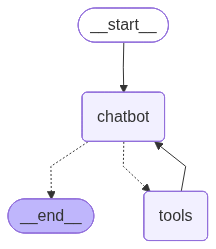

In [81]:
from IPython.display import Image , display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [82]:
user_input = "I need some expert guidence for building AI Agent.Could you request assistance for me"

config={"configurable":{"thread_id":"1"}}

events =  graph.stream({"messages":user_input},config,stream_mode="values",)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidence for building AI Agent.Could you request assistance for me
================================== Ai Message ==================================
Tool Calls:
  human_assistance (abcpz40m7)
 Call ID: abcpz40m7
  Args:
    query: Expert guidance for building AI Agent
  human_assistance (v1q38qwka)
 Call ID: v1q38qwka
  Args:
    query: Additional guidance on building AI Agent
  human_assistance (yd5w1sq37)
 Call ID: yd5w1sq37
  Args:
    query: Specific guidance on AI Agent architecture and design


In [83]:
human_response = ("We,the experts are here to help! We'd recommend you check out LangGraph"
" to build your agent"
                  "Its much more reliable and extensable than simple autonomous agents")

human_command = Command(resume={"data": human_response})

events =  graph.stream(human_command,config,stream_mode="values")

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (abcpz40m7)
 Call ID: abcpz40m7
  Args:
    query: Expert guidance for building AI Agent
  human_assistance (v1q38qwka)
 Call ID: v1q38qwka
  Args:
    query: Additional guidance on building AI Agent
  human_assistance (yd5w1sq37)
 Call ID: yd5w1sq37
  Args:
    query: Specific guidance on AI Agent architecture and design


MCP Implementation
MCP (Model Context Protocol) is an open-source standard for connecting AI applications to external systems.